# Keep Calm and carry On

### 회귀에 필요한 함수를 넣어 놓았읍니다

### 천천히 보십쇼


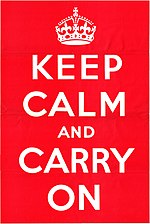

In [23]:
import pandas as pd
from google.colab import drive
from pandas import Series, DataFrame
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
from pandas import DataFrame
from pandas import concat
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [25]:
############ 파라미터 #####################
# 하루의 틱
ticks = 48
############### 예측에 사용할 일수 ################
# days를 수정하면 이전의 n 일이 불러와진다!!
# 일단 3일로 설정해 놓았음.
days = 3
n_days = ticks*days

# 미래 예측할 일수
future_days = 2
future_window = ticks * future_days

### 모든변수
# ['Hour', 'Minute', 'Day', 'WS', 'Time', 'DHI','DNI','RH','T','TARGET']
# 사용할 변수
what_to_use = ['Time', 'DHI','DNI','RH','T','TARGET']

n_features = len(what_to_use)
n_obs = n_days * n_features

# 한 번에 뭉테기로 투입할 자료의 양
batches = 100
# 몇 번이나 반복하여 학습할 것인다.
epoch = 200

In [ ]:
###### 회귀분석 전처리 추천 작업 순서 #########


# 일단 불러오기
raw_data = pd.read_csv('/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/train/train.csv')

# 칼럼 안쓰는 거 떼어내기
dataset = drop_clms(raw_data)

# 변수 2개, 앞의 변수는 raw_data 뒤에 변수는 파라미터 항목에서 이전 며칠을 불러올 것인지 정의한 것.
# 잘 모르겠으면 일단 돌려보고 단계별로 print(dataset) 해서 살펴보면 알 수 있을 듯...
dataset2 = series_to_supervised(dataset, n_days)

# train_X, train_y, test_X, test_y로 분리하는 함수.
dataset3 = seperator(dataset2)

In [27]:
def drop_clms(dataset):
  dataset['Time'] = dataset['Hour'] + dataset['Minute']*(0.5/30)
  dataset = dataset[what_to_use]
  return dataset

In [31]:
# 머신러닝에 쓰기 위해서 재정렬 시키는 함수
def series_to_supervised(data, n_in, target = 'TARGET', dropnan=True):
    df = DataFrame(data)
    df2 = DataFrame(data[target])
    cols, names = list(), list()
    future = [48,96]
    n_vars = 1 if type(df) is list else df.shape[1]
    n_vars2 = 1 if type(df2) is list else df2.shape[1]
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in future:
        cols.append(df2.shift(-i))
        if i == 0:
            names += [('TARGET%d(t)' % (j+1)) for j in range(n_vars2)]
        else:
            names += [('TARGET%d(t+%d)' % (j+1, i)) for j in range(n_vars2)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [32]:
def seperator(dataset):
  
  # series_to_supervised 함수를 지나며 전처리를 하면 하나의 row에 이전 7일간의 데이터가 일렬로 들어가고(train), 여기에 target으로 미래 96일 발전량이 따라 붙는다.
  # 이 둘이 한 줄에 있으므로 적절한 지점에서 잘라서 train_X와 train_y로 사용한다.
  X = dataset.iloc[:, :n_obs]
  y = dataset.iloc[:, -future_window:]
  
  # validation을 해야하니까, train으로 준 데이터를 train/test로 자른다.
  # 사용가능한 연도가 3개년이고, 대충 train에 2년치, test에 1년치를 주었다 (7:3)
  # 42 = ultimate answer to life the universe and everything
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

  # 학습과 검증 데이터를 원하는 모양([1,4,2]) 이런 식으로 바꾸는 함수
  #### 처음 모양 (36490, 2016)
  # 2년치가 데이터(730일 * 하루에 48틱 = 36490개)로 있고, 이전 일주일 데이터 7*48 = 336인데 사용한 변수가 6개라면 336*6이다.
  # 일단 2016개의 데이터를 틱별로(30분 단위로) 잘라준다
  # 한 틱에 6개의 변수가 들어간다면 이를 n_features로 반영
  
  #### 수정할 모양 (36490, 336, 6)
  # 6개 특징이 30분 단위로 336개(일주일) 준비되어 있다.
  # 이런 데이터가 36490개 있어서 학습에 사용할 수 있다.

  # y 데이터는 1개 변수(발전량)만 나오고, 미래 2일 (2*48 = 96틱)이므로
  # 형태 ('총 데이터의 개수', '미래/과거의 길이', '사용한 변수의 개수')
  # == (36490, 96, 1) 으로 reshape 한다.

  train_X = X_train.values
  train_X = train_X.reshape(train_X.shape[0],-1,n_features)
  train_y = y_train.values
  train_y = train_y.reshape(train_y.shape[0],future_window)

  test_X = X_test.values
  test_X = test_X.reshape(test_X.shape[0],-1,n_features)
  test_y = y_test.values
  test_y = test_y.reshape(test_y.shape[0],future_window)

  return train_X, train_y, test_X, test_y